In [33]:
import pickle
import pandas as pd
import numpy as np
import zentables as zen
import seaborn as sns

from scipy import stats
from statistics import median
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import clear_output

import time
import datetime

print(datetime.datetime.now())

2023-07-27 23:49:36.329124


In [2]:
path_data = '../data/d20220201/'

# INPUTS
fn_finalSave = path_data + 'featuresAndMeta_s20220720.p'

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['font.size'] = 10
plt.rcParams['figure.autolayout']=False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# OUTPUTS
fn_f_ptchar1 = '../figures/f_patientChar1_s20220821.svg'
fn_f_ptchar2 = '../figures/f_patientChar2_s20220821.svg'
fn_f_ptchar1_swarm = '../figures/f_patientChar1swarm_s20220821.svg'
fn_f_ptchar2_swarm = '../figures/f_patientChar2swarm_s20220821.svg'

In [3]:
with open(fn_finalSave, "rb") as input_file:
    dict_data = pickle.load(input_file)

dict_data.keys()

dict_keys(['df_rawFeatures_training', 'df_rawFeatures_validation', 'dict_normalizationFactors', 'df_zscoreFeatures_training', 'df_zscoreFeatures_validation', 'df_metadata', 'umap_raw', 'umap_zscore'])

In [ ]:
df_meta = dict_data['df_metadata']

In [5]:
df_meta.columns

Index(['trainTest', 'age', 'sex', 'ct_grp', 'lre', 'lre_tf', 'decompBL', 'lrd',
       'lrd_tf', 'survival', 'survival_tf', 'tfs', 'tfs_tf', 'hvpg_corrected',
       'hvpg_grp', 'decompensated_acld', 'hepLrd_time', 'hepLrd_180',
       'hepLrd_360', 'cps', 'cps_grp', 'meld', 'meld_grp', 'etiology',
       'sodium', 'creatinine', 'albumin', 'CRP', 'INR', 'bilirubin',
       'cntl_grp', 'patientID'],
      dtype='object')

In [6]:
print(df_meta[(df_meta['trainTest']=='0') & (df_meta['cntl_grp']==0)]['hvpg_corrected'].mean())
print(df_meta[(df_meta['trainTest']=='0') & (df_meta['cntl_grp']==0)]['hvpg_corrected'].median())
print(df_meta[(df_meta['trainTest']=='0') & (df_meta['cntl_grp']==0)]['hvpg_corrected'].min())
print(df_meta[(df_meta['trainTest']=='0') & (df_meta['cntl_grp']==0)]['hvpg_corrected'].max())

15.544817927170868
16.0
0.0
66.0


In [7]:
print(df_meta[(df_meta['trainTest']=='1') & (df_meta['cntl_grp']==0)]['hvpg_corrected'].mean())
print(df_meta[(df_meta['trainTest']=='1') & (df_meta['cntl_grp']==0)]['hvpg_corrected'].median())
print(df_meta[(df_meta['trainTest']=='1') & (df_meta['cntl_grp']==0)]['hvpg_corrected'].min())
print(df_meta[(df_meta['trainTest']=='1') & (df_meta['cntl_grp']==0)]['hvpg_corrected'].max())

15.494117647058824
17.0
2.0
41.0


In [26]:
df_meta.columns

Index(['trainTest', 'age', 'sex', 'ct_grp', 'lre', 'lre_tf', 'decompBL', 'lrd',
       'lrd_tf', 'survival', 'survival_tf', 'tfs', 'tfs_tf', 'hvpg_corrected',
       'hvpg_grp', 'decompensated_acld', 'hepLrd_time', 'hepLrd_180',
       'hepLrd_360', 'cps', 'cps_grp', 'meld', 'meld_grp', 'etiology',
       'sodium', 'creatinine', 'albumin', 'CRP', 'INR', 'bilirubin',
       'cntl_grp', 'patientID'],
      dtype='object')

In [40]:
train = df_meta[df_meta['trainTest']=='0']
train = train[train['cntl_grp']==0]
test = df_meta[df_meta['trainTest']=='1']
test = test[test['cntl_grp']==0]
everyone = df_meta[df_meta['cntl_grp']==0]

print(median(train['lrd']))
print(median(test['lrd']))
print(median(everyone['lrd']))
stats.ks_2samp(train['lrd'], test['lrd'], alternative='two-sided')


27.876397107166337
24.786324786324784
27.2189349112426


Ks_2sampResult(statistic=0.0784313725490196, pvalue=0.7606266500948834)

In [8]:
temp = {}
for colName, key in zip(['All', 'Training', 'Validation'], [['0', '1'], ['0'], ['1']]):
    currMeta = df_meta[df_meta['trainTest'].isin(key)]
    currMeta = currMeta.dropna()
    totPatients = len(currMeta)
    currCol = {'Age, mean (SD)': "%.1f (%.1f)" %(currMeta['age'].mean(), currMeta['age'].std()),
               'Male, n (%)': "%d (%.1f%%)" %(len(currMeta[currMeta['sex']=='1']), len(currMeta[currMeta['sex']=='1'])/totPatients*100),
               'Female, n (%)': "%d (%.1f%%)" %(len(currMeta[currMeta['sex']=='0']), len(currMeta[currMeta['sex']=='0'])/totPatients*100),
               'HVPG in mmHg, mean (SD)': "%.1f (%.1f)" %(currMeta['hvpg_corrected'].mean(), currMeta['hvpg_corrected'].std()),
               'Etiology, n (%)': '',
               '   Alcoholic liver disease': "%d (%.1f%%)" %(len(currMeta[currMeta['etiology']=='1']), len(currMeta[currMeta['etiology']=='1'])/totPatients*100),
               '   Non-alcoholic fatty liver': "%d (%.1f%%)" %(len(currMeta[currMeta['etiology']=='2']), len(currMeta[currMeta['etiology']=='2'])/totPatients*100),
               '   Viral': "%d (%.1f%%)" %(len(currMeta[currMeta['etiology']=='3']), len(currMeta[currMeta['etiology']=='3'])/totPatients*100),
               '   Other': "%d (%.1f%%)" %(len(currMeta[currMeta['etiology']=='4']), len(currMeta[currMeta['etiology']=='4'])/totPatients*100),
               '   Unknown': "%d (%.1f%%)" %(len(currMeta[currMeta['etiology']=='5']), len(currMeta[currMeta['etiology']=='5'])/totPatients*100),
               'CT group, n (%)': '',
               '    Group 1':  "%d (%.1f%%)" %(len(currMeta[currMeta['ct_grp']=='1']), len(currMeta[currMeta['ct_grp']=='1'])/totPatients*100),
               '    Group 2':  "%d (%.1f%%)" %(len(currMeta[currMeta['ct_grp']=='2']), len(currMeta[currMeta['ct_grp']=='2'])/totPatients*100),
               '    Group 3':  "%d (%.1f%%)" %(len(currMeta[currMeta['ct_grp']=='3']), len(currMeta[currMeta['ct_grp']=='3'])/totPatients*100),
               '    Group 5':  "%d (%.1f%%)" %(len(currMeta[currMeta['ct_grp']=='5']), len(currMeta[currMeta['ct_grp']=='5'])/totPatients*100),
               '    Group 6':  "%d (%.1f%%)" %(len(currMeta[currMeta['ct_grp']=='6']), len(currMeta[currMeta['ct_grp']=='6'])/totPatients*100),
               'Child-Pugh score, n (SD)': "%.1f (%.1f)" %(currMeta['cps'].mean(), currMeta['cps'].std()),
               'MELD UNOS 2012 score, n (SD)': "%.1f (%.1f)" %(currMeta['meld'].mean(), currMeta['meld'].std()),
               'Sodium, mean (SD)': "%d (%.1f)" %(currMeta['sodium'].mean(), currMeta['sodium'].std()),
               'Creatinine, mean (SD)': "%d (%.1f)" %(currMeta['creatinine'].mean(), currMeta['creatinine'].std()),
               'Albumin, mean (SD)': "%d (%.1f)" %(currMeta['albumin'].mean(), currMeta['albumin'].std()),
               'CRP, mean (SD)': "%d (%.1f)" %(currMeta['CRP'].mean(), currMeta['CRP'].std()),
               'INR, mean (SD)': "%d (%.1f)" %(currMeta['INR'].mean(), currMeta['INR'].std()),
               'Bilirubin, mean (SD)': "%d (%.1f)" %(currMeta['bilirubin'].mean(), currMeta['bilirubin'].std()),
              }
    temp[colName] = currCol
toTable = pd.DataFrame.from_records(temp)

In [9]:
#                'Child-Pugh score, n (%)': '',
#                '    Class A':  "%d (%.2f%%)" %(len(currMeta[currMeta['cps_grp']=='1']), len(currMeta[currMeta['cps_grp']=='1'])/totPatients*100),
#                '    Class B':  "%d (%.2f%%)" %(len(currMeta[currMeta['cps_grp']=='2']), len(currMeta[currMeta['cps_grp']=='2'])/totPatients*100),
#                '    Class C':  "%d (%.2f%%)" %(len(currMeta[currMeta['cps_grp']=='3']), len(currMeta[currMeta['cps_grp']=='3'])/totPatients*100),
#                'MELD UNOS 2012 score, n (%)': '',
#                '    Class 0':  "%d (%.2f%%)" %(len(currMeta[currMeta['meld_grp']=='0']), len(currMeta[currMeta['meld_grp']=='0'])/totPatients*100),
#                '    Class 1':  "%d (%.2f%%)" %(len(currMeta[currMeta['meld_grp']=='1']), len(currMeta[currMeta['meld_grp']=='1'])/totPatients*100),
#                '    Class 2':  "%d (%.2f%%)" %(len(currMeta[currMeta['meld_grp']=='2']), len(currMeta[currMeta['meld_grp']=='2'])/totPatients*100),


In [10]:
toTable.zen.pretty()

,All,Training,Validation
"Age, mean (SD)",57.4 (11.7),57.6 (11.5),57.0 (12.4)
"Male, n (%)",314 (71.0%),254 (71.1%),60 (70.6%)
"Female, n (%)",128 (29.0%),103 (28.9%),25 (29.4%)
"HVPG in mmHg, mean (SD)",15.5 (8.1),15.5 (8.1),15.5 (8.4)
"Etiology, n (%)",,,
Alcoholic liver disease,184 (41.6%),149 (41.7%),35 (41.2%)
Non-alcoholic fatty liver,45 (10.2%),40 (11.2%),5 (5.9%)
Viral,113 (25.6%),89 (24.9%),24 (28.2%)
Other,86 (19.5%),69 (19.3%),17 (20.0%)
Unknown,14 (3.2%),10 (2.8%),4 (4.7%)


In [12]:
# change sex / trainTest symbols to make legends informative
temp_dict = {'0': 'female', '1': 'male'}
df_meta['sex'] = df_meta['sex'].apply(lambda x: temp_dict[x] if x in temp_dict.keys() else x)

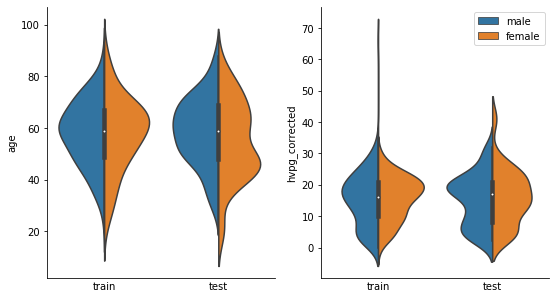

In [14]:
f, axs = plt.subplots(1,2,figsize=(9,5))

sns.violinplot(data=df_meta,
               x='trainTest', y='age', hue='sex', 
               split=True, bw=0.4, legend=False,
               ax=axs[0])
# sns.swarmplot(data=df_meta,
#               x='trainTest', y='age', hue='sex', 
#               #split=True, color="white",
#               ax=axs[0])

sns.violinplot(data=df_meta,
               x='trainTest', y='hvpg_corrected', hue='sex', 
               split=True, bw=0.4,
               ax=axs[1])

for ax in axs:
    ax.get_legend().remove()
    ax.set_xticklabels(['train', 'test'])
    ax.tick_params(axis='x', which='both', length=0)
    ax.set_xlabel('')
plt.legend(bbox_to_anchor=(0.98, 0.98), loc='upper right', borderaxespad=0)

#plt.savefig(fn_f_ptchar1, bbox_inches='tight')

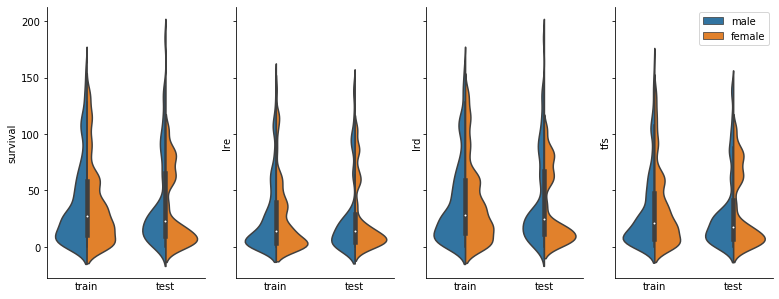

In [15]:
f, axs = plt.subplots(1,4,
                      figsize=(13,5),
                      sharey=True)

sns.violinplot(data=df_meta,
               x='trainTest', y='survival', hue='sex', 
               split=True, bw=0.2,
               ax=axs[0])
sns.violinplot(data=df_meta,
               x='trainTest', y='lre', hue='sex', 
               split=True, bw=0.2,
               ax=axs[1])
sns.violinplot(data=df_meta,
               x='trainTest', y='lrd', hue='sex', 
               split=True, bw=0.2,
               ax=axs[2])
sns.violinplot(data=df_meta,
               x='trainTest', y='tfs', hue='sex', 
               split=True, bw=0.2,
               ax=axs[3])

for ax in axs:
    ax.get_legend().remove()
    ax.set_xticklabels(['train', 'test'])
    ax.tick_params(axis='x', which='both', length=0)
    ax.set_xlabel('')
plt.legend(bbox_to_anchor=(0.98, 0.98), loc='upper right', borderaxespad=0)

#plt.savefig(fn_f_ptchar2, bbox_inches='tight')

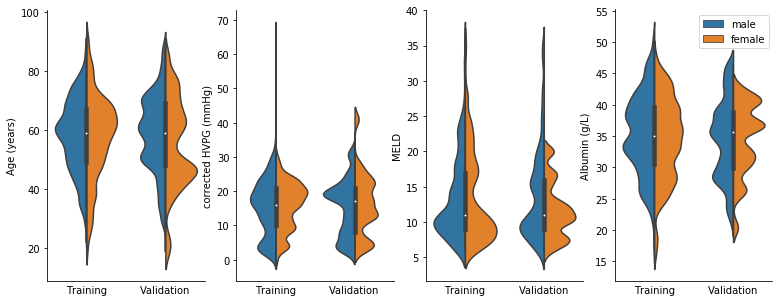

In [16]:
f, axs = plt.subplots(1,4,
                      figsize=(13,5),
                      sharey=False)

# 1st row
# age, HVPG, MELD, Albumin
sns.violinplot(data=df_meta,
               x='trainTest', y='age', hue='sex', 
               split=True, bw=0.2,
               ax=axs[0])
axs[0].set_ylabel('Age (years)')
sns.violinplot(data=df_meta,
               x='trainTest', y='hvpg_corrected', hue='sex', 
               split=True, bw=0.2,
               ax=axs[1])
axs[1].set_ylabel('corrected HVPG (mmHg)')
sns.violinplot(data=df_meta,
               x='trainTest', y='meld', hue='sex', 
               split=True, bw=0.2,
               ax=axs[2])
axs[2].set_ylabel('MELD')
sns.violinplot(data=df_meta,
               x='trainTest', y='albumin', hue='sex', 
               split=True, bw=0.2,
               ax=axs[3])
axs[3].set_ylabel('Albumin (g/L)')

# 2nd row:
# Liver-related events, liver-related death, transplant-free survival, overall survival

for ax in axs:
    ax.get_legend().remove()
    ax.set_xticklabels(['Training', 'Validation'])
    ax.tick_params(axis='x', which='both', length=0)
    ax.set_xlabel('')
plt.legend(bbox_to_anchor=(0.98, 0.98), loc='upper right', borderaxespad=0)

plt.savefig(fn_f_ptchar1, bbox_inches='tight')

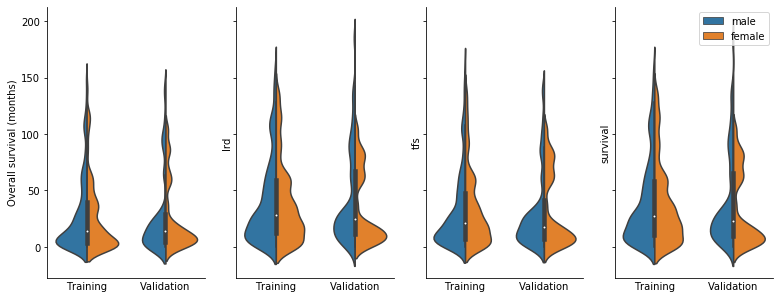

In [17]:
f, axs = plt.subplots(1,4,
                      figsize=(13,5),
                      sharey=True)

# 2nd row:
# Liver-related events, liver-related death, transplant-free survival, overall survival
sns.violinplot(data=df_meta,
               x='trainTest', y='lre', hue='sex', 
               split=True, bw=0.2,
               ax=axs[0])
axs[0].set_ylabel('Liver-related events (months)')
sns.violinplot(data=df_meta,
               x='trainTest', y='lrd', hue='sex', 
               split=True, bw=0.2,
               ax=axs[1])
axs[0].set_ylabel('Liver-related death (months)')
sns.violinplot(data=df_meta,
               x='trainTest', y='tfs', hue='sex', 
               split=True, bw=0.2,
               ax=axs[2])
axs[0].set_ylabel('Transplant-free survival (months)')
sns.violinplot(data=df_meta,
               x='trainTest', y='survival', hue='sex', 
               split=True, bw=0.2,
               ax=axs[3])
axs[0].set_ylabel('Overall survival (months)')

for ax in axs:
    ax.get_legend().remove()
    ax.set_xticklabels(['Training', 'Validation'])
    ax.tick_params(axis='x', which='both', length=0)
    ax.set_xlabel('')
plt.legend(bbox_to_anchor=(0.98, 0.98), loc='upper right', borderaxespad=0)

plt.savefig(fn_f_ptchar2, bbox_inches='tight')

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:2971: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


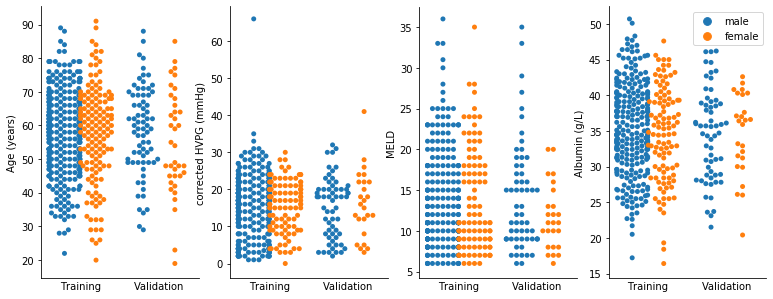

In [18]:
f, axs = plt.subplots(1,4,
                      figsize=(13,5),
                      sharey=False)

# 1st row
# age, HVPG, MELD, Albumin
sns.swarmplot(data=df_meta,
               x='trainTest', y='age', hue='sex',
               split=True,
               ax=axs[0])
axs[0].set_ylabel('Age (years)')
sns.swarmplot(data=df_meta,
               x='trainTest', y='hvpg_corrected', hue='sex', 
               split=True,
               ax=axs[1])
axs[1].set_ylabel('corrected HVPG (mmHg)')
sns.swarmplot(data=df_meta,
               x='trainTest', y='meld', hue='sex', 
               split=True,
               ax=axs[2])
axs[2].set_ylabel('MELD')
sns.swarmplot(data=df_meta,
               x='trainTest', y='albumin', hue='sex', 
               split=True,
               ax=axs[3])
axs[3].set_ylabel('Albumin (g/L)')

# 2nd row:
# Liver-related events, liver-related death, transplant-free survival, overall survival

for ax in axs:
    ax.get_legend().remove()
    ax.set_xticklabels(['Training', 'Validation'])
    ax.tick_params(axis='x', which='both', length=0)
    ax.set_xlabel('')
plt.legend(bbox_to_anchor=(0.98, 0.98), loc='upper right', borderaxespad=0)

plt.savefig(fn_f_ptchar1_swarm, bbox_inches='tight')

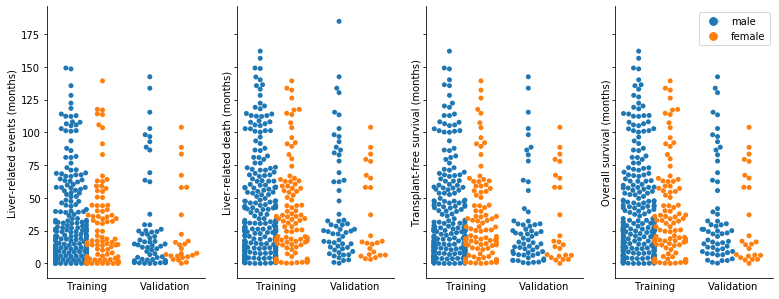

In [19]:
f, axs = plt.subplots(1,4,
                      figsize=(13,5),
                      sharey=True)

# 2nd row:
# Liver-related events, liver-related death, transplant-free survival, overall survival
sns.swarmplot(data=df_meta,
               x='trainTest', y='lre', hue='sex', 
               split=True,
               ax=axs[0])
axs[0].set_ylabel('Liver-related events (months)')
sns.swarmplot(data=df_meta,
               x='trainTest', y='lrd', hue='sex', 
               split=True,
               ax=axs[1])
axs[1].set_ylabel('Liver-related death (months)')
sns.swarmplot(data=df_meta,
               x='trainTest', y='tfs', hue='sex', 
               split=True,
               ax=axs[2])
axs[2].set_ylabel('Transplant-free survival (months)')
sns.swarmplot(data=df_meta,
               x='trainTest', y='survival', hue='sex', 
               split=True,
               ax=axs[3])
axs[3].set_ylabel('Overall survival (months)')

for ax in axs:
    ax.get_legend().remove()
    ax.set_xticklabels(['Training', 'Validation'])
    ax.tick_params(axis='x', which='both', length=0)
    ax.set_xlabel('')
plt.legend(bbox_to_anchor=(0.98, 0.98), loc='upper right', borderaxespad=0)

plt.savefig(fn_f_ptchar2_swarm, bbox_inches='tight')

In [20]:
print(datetime.datetime.now())

2023-05-16 13:03:25.602372
